<a href="https://colab.research.google.com/github/gabriquaranta/thesis/blob/main/yolo5_adversarial_patch_minitest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# YOLOv5
!git clone https://github.com/ultralytics/yolov5.git
!pip install -qr yolov5/requirements.txt

# Download a sample image (the "Zidane" image used in many YOLOv5 demos)
!wget -q https://ultralytics.com/images/zidane.jpg

Cloning into 'yolov5'...
remote: Enumerating objects: 17270, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 17270 (delta 0), reused 0 (delta 0), pack-reused 17269 (from 2)
Receiving objects: 100% (17270/17270), 16.10 MiB | 16.92 MiB/s, done.
Resolving deltas: 100% (11855/11855), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# Load the pre-trained YOLOv5 model via torch.hub.
# We use yolov5s (the small model) for speed.
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-2-4 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 117MB/s] 

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [4]:
# Load the sample image, convert it to RGB, then transform it to a tensor.
img_path = "zidane.jpg"
img = Image.open(img_path).convert("RGB")
transform = transforms.Compose([
    transforms.ToTensor(),  # scales image to [0, 1]
])
img_tensor = transform(img).unsqueeze(0)  # shape: (1, 3, H, W)

# Resize image to a fixed size (e.g. 640x640) to ensure consistent feature map sizes in YOLOv5.
img_tensor = F.interpolate(img_tensor, size=(640, 640), mode='bilinear', align_corners=False)
img_tensor = img_tensor.to(device)
print("Image tensor shape:", img_tensor.shape)


Image tensor shape: torch.Size([1, 3, 640, 640])


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 720x1280 2 persons, 1 tie, 1 cell phone
Speed: 34.6ms pre-process, 66.6ms inference, 355.9ms NMS per image at shape (1, 3, 384, 640)


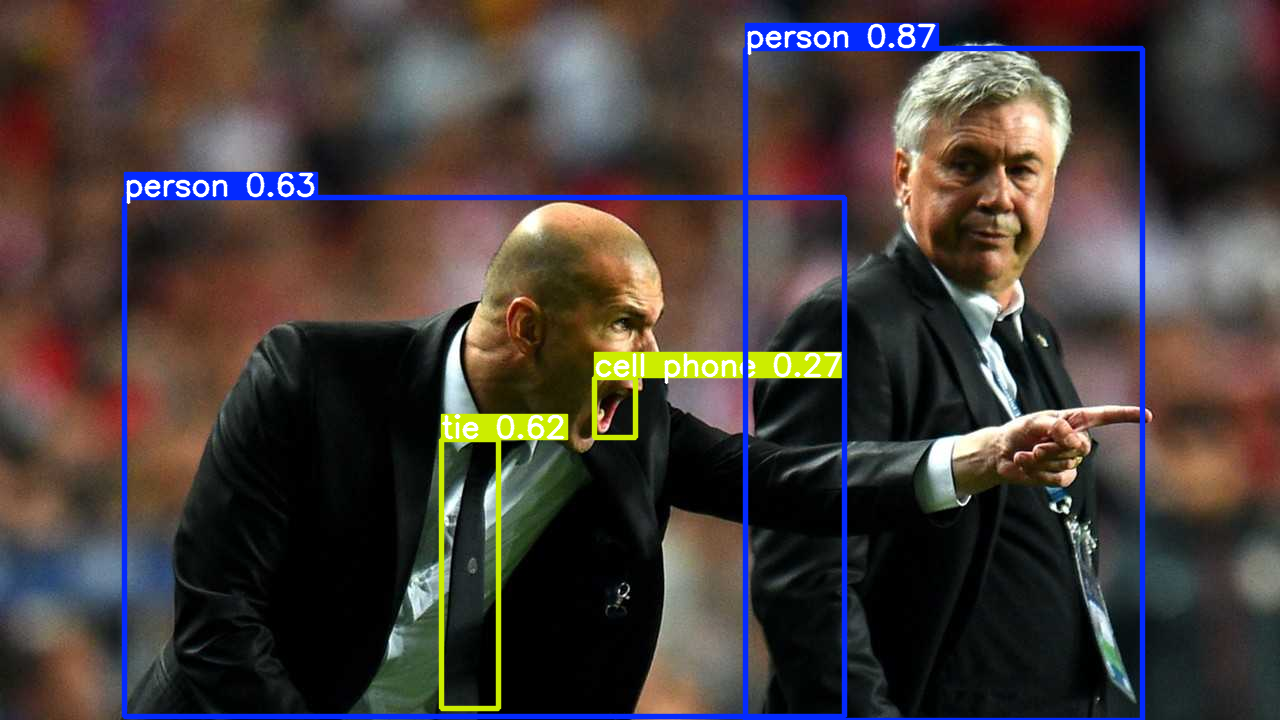

In [5]:
# Inference on base image
results = model(img_path)

results.print()
results.show()

In [6]:
# To allow gradient flow through the network we set the model to train mode.
model.train()
model = model.to(device)

# Note: We will use the underlying model (accessible via model.model) to obtain raw predictions.
# This bypasses post-processing (NMS) so that the outputs are differentiable.

In [7]:
# Define a learnable adversarial patch.
# Here, we simply parameterize a patch (with dimensions 3 x patch_size x patch_size)
patch_size = 50
# Initialize the patch with random noise
adv_patch = nn.Parameter(torch.rand(1, 3, patch_size, patch_size, device=device), requires_grad=True)

In [8]:
def apply_patch(image, patch):
    """
    Applies the adversarial patch to the image at a random location.

    Parameters:
      image: Tensor of shape (1, 3, H, W)
      patch: Tensor of shape (1, 3, ph, pw)

    Returns:
      patched_image: Tensor with the patch applied.
    """
    _, _, H, W = image.shape
    _, _, ph, pw = patch.shape

    # Ensure the patch fits within the image dimensions.
    if W < pw or H < ph:
        raise ValueError("Patch dimensions are larger than the image dimensions.")

    # Choose a random location ensuring the patch fits entirely in the image.
    x = random.randint(0, W - pw)
    y = random.randint(0, H - ph)

    # Optionally, if you want to calculate padding (for example, if the patch goes out-of-bound),
    # do it after x and y are set. In this toy example, the patch is guaranteed to fit.
    # pad_x = max(0, pw - x)  # Not needed as x is chosen so that x+pw <= W
    # pad_y = max(0, ph - y)  # Not needed as y is chosen so that y+ph <= H

    patched_image = image.clone()
    # Overwrite the selected region with the patch.
    patched_image[:, :, y:y+ph, x:x+pw] = patch
    return patched_image


In [9]:
# Define a simple loss function.
# In this toy example, we will use the mean squared error (MSE) between the raw outputs
# (before NMS) of the YOLO model on the clean and patched images.
criterion = nn.MSELoss()

# Define two optimizers:
# 1. yolo_optimizer updates the YOLO model parameters (aiming to reduce the impact of the patch)
# 2. gen_optimizer updates the adversarial patch (aiming to cause maximal disruption)
yolo_optimizer = optim.Adam(model.parameters(), lr=1e-4)
gen_optimizer = optim.Adam([adv_patch], lr=1e-2)

In [10]:
# Cell 8: Training Loop for Tandem Adversarial Training
n_epochs = 50

for epoch in range(n_epochs):
    # 1. Compute baseline predictions on the clean image using the differentiable model output.
    baseline_preds = model.model(img_tensor)

    # 2. Create a patched version of the image.
    patched_img = apply_patch(img_tensor, adv_patch)

    # 3. Forward pass on the patched image.
    patched_preds = model.model(patched_img)

    # Stage A: Update YOLO model to be robust against the patch.
    # Compute the loss for each output tensor and average them.
    loss_yolo = 0
    for p, bp in zip(patched_preds, baseline_preds):
        loss_yolo += criterion(p, bp.detach())
    loss_yolo = loss_yolo / len(patched_preds)

    #yolo_optimizer.zero_grad()
    #loss_yolo.backward(retain_graph=True)
    #yolo_optimizer.step()

    # Stage B: Update the adversarial patch.
    # Recompute predictions after YOLO update
    patched_preds = model.model(patched_img)
    loss_gen = 0
    for p, bp in zip(patched_preds, baseline_preds):
        loss_gen += -criterion(p, bp.detach())
    loss_gen = loss_gen / len(patched_preds)

    gen_optimizer.zero_grad()
    loss_gen.backward()
    gen_optimizer.step()

    print(f"Epoch {epoch+1}/{n_epochs} | YOLO Loss: {loss_yolo.item():.4f} | Gen Loss: {loss_gen.item():.4f}")


Epoch 1/50 | YOLO Loss: 0.0157 | Gen Loss: -0.0157
Epoch 2/50 | YOLO Loss: 0.0365 | Gen Loss: -0.0365
Epoch 3/50 | YOLO Loss: 0.0368 | Gen Loss: -0.0368
Epoch 4/50 | YOLO Loss: 0.0403 | Gen Loss: -0.0403
Epoch 5/50 | YOLO Loss: 0.0343 | Gen Loss: -0.0343
Epoch 6/50 | YOLO Loss: 0.0751 | Gen Loss: -0.0751
Epoch 7/50 | YOLO Loss: 0.0488 | Gen Loss: -0.0488
Epoch 8/50 | YOLO Loss: 0.0247 | Gen Loss: -0.0247
Epoch 9/50 | YOLO Loss: 0.0338 | Gen Loss: -0.0338
Epoch 10/50 | YOLO Loss: 0.0288 | Gen Loss: -0.0288
Epoch 11/50 | YOLO Loss: 0.0889 | Gen Loss: -0.0889
Epoch 12/50 | YOLO Loss: 0.0794 | Gen Loss: -0.0794
Epoch 13/50 | YOLO Loss: 0.0449 | Gen Loss: -0.0449
Epoch 14/50 | YOLO Loss: 0.0415 | Gen Loss: -0.0415
Epoch 15/50 | YOLO Loss: 0.0272 | Gen Loss: -0.0272
Epoch 16/50 | YOLO Loss: 0.0600 | Gen Loss: -0.0600
Epoch 17/50 | YOLO Loss: 0.0446 | Gen Loss: -0.0446
Epoch 18/50 | YOLO Loss: 0.0427 | Gen Loss: -0.0427
Epoch 19/50 | YOLO Loss: 0.0308 | Gen Loss: -0.0308
Epoch 20/50 | YOLO Lo

In [11]:
# Apply the patch to the image
patched_img = apply_patch(img_tensor, adv_patch)

# Debug: Print tensor statistics
print("Patched image min:", patched_img.min().item(), "max:", patched_img.max().item())

# Convert the tensor to a NumPy array
patched_np = patched_img.squeeze().permute(1, 2, 0).detach().cpu().numpy()
patched_np = np.clip(patched_np, 0, 1)
print("Patched image shape:", patched_np.shape)

# Plot the image
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.imshow(patched_np)
plt.title("Patched Image")
plt.axis("off")
plt.savefig("patched_image.png")  # Optionally save the image
plt.show()

Patched image min: -0.2351783663034439 max: 1.3179644346237183
Patched image shape: (640, 640, 3)


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 640x640 2 persons, 1 tie
Speed: 24.1ms pre-process, 12.3ms inference, 3.3ms NMS per image at shape (1, 3, 640, 640)


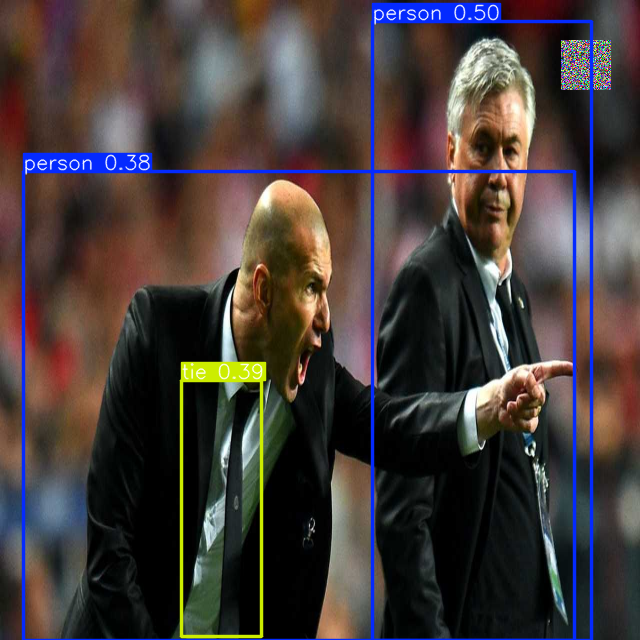

In [12]:
# Convert the patched tensor to a NumPy array for inference
patched_np = patched_img.squeeze().permute(1, 2, 0).detach().cpu().numpy()
# Scale the image from [0,1] to [0,255] and convert to uint8
patched_np = (patched_np * 255).astype(np.uint8)

# Run inference on the numpy array
model.eval()
results = model(patched_np)

results.print()
results.show()
